In [1]:
####  the precipitation maps for P99 precipitation.

In [10]:
import numpy as np
import os
import glob
import datetime
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy 
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from netCDF4 import Dataset
import matplotlib.path as mplPath
from Tracking_Functions_pr_objects_fin import interpolate
from Tracking_Functions_pr_objects_fin import interp_weights

In [11]:
def cal_vtx_wts(COORDINATES, Lat, Lon):
    # read in the coordinates
    ncid=Dataset(COORDINATES[0], mode='r')
    LatM=np.squeeze(ncid.variables[COORDINATES[1]][:])
    LonM=np.squeeze(ncid.variables[COORDINATES[2]])
    ncid.close()

    # define area with valid data after regridding
    rgrGridCells=[(Lon.ravel()[ii],Lat.ravel()[ii]) for ii in range(len(Lon.ravel()))]
    
    first = np.append(LonM[0,:][:,None],LatM[0,:][:,None], axis=1)
    second = np.append(LonM[:,0][:,None],LatM[:,0][:,None], axis=1)
    third = np.append(LonM[-1,:][:,None],LatM[-1,:][:,None], axis=1)
    fourth = np.append(LonM[:,-1][:,None],LatM[:,-1][:,None], axis=1)
    array_tuple = (first, second, third[::-1], fourth[::-1])
    ctr = np.vstack(array_tuple)
    
    grPRregion=mplPath.Path(ctr)
    TMP=np.array(grPRregion.contains_points(rgrGridCells))
    rgrSRactP=np.zeros((Lon.shape[0]*Lon.shape[1]))
    rgrSRactP[TMP == 1]=1
    rgrSRactP=np.reshape(rgrSRactP, (Lat.shape[0], Lat.shape[1]))
    rgrSRactP.shape
    # Remap Model to Target grid
    points=np.array([LonM.flatten(), LatM.flatten()]).transpose()   
    vtx, wts = interp_weights(points, np.append(Lon.flatten()[:,None], Lat.flatten()[:,None], axis=1))
    return vtx, wts, rgrSRactP

In [12]:
def plot_2d(lat, lon, data_2d, color_map, title_s):
    fig = plt.figure(figsize=(10,14))

    # Set the axes using the specified map projection
    ax=plt.axes(projection=ccrs.PlateCarree())
    
    # Make a filled contour plot
    filled_c = ax.contourf(lon, lat, data_2d,
                           levels =np.arange(0, 6, 0.5), extend='both',
                           cmap = color_map, transform = ccrs.PlateCarree())

    # Add coastlines
    ax.coastlines()
    ax.add_feature(cfeature.STATES, zorder=1, linewidth=.3, edgecolor='black')
    ax.set_title(title_s)
    
    ax = plt.gca()
    ax.gridlines(draw_labels=True)   
    # or..
    #ax.set_xticks([-40, -20, 0, 20, 40], crs=ccrs.PlateCarree())

    # Add a colorbar for the filled contour.
    # and pad argument to set colorbar away from x-axis
    fig.colorbar(filled_c,  label= 'mm/hr', pad = 0.05, fraction=0.04, orientation="horizontal"); # 

In [45]:
def plot_p4(res, type_s, Lat, Lon, dataset, data_3d):
    n_ds = len(dataset)
    level_s = np.arange(0,6,0.5)

    
    nrow = int(np.ceil(n_ds/2))
    ncol = 2
    fig, ax = plt.subplots(nrow, ncol,figsize=(12,8), \
                           subplot_kw={'projection': ccrs.PlateCarree()})

    for ds in range(n_ds):
        nr = int(ds/ncol)
        nc = int((ds%ncol))
        data_2d = data_3d[ds]
        im=ax[nr,nc].contourf(Lon, Lat, data_2d, transform=ccrs.PlateCarree(), 
                        extend='both', levels=level_s, cmap = 'Spectral_r')
        fig.colorbar(im, ax=ax[nr,nc], shrink=0.9, location="bottom")
        ax[nr,nc].coastlines()
        ax[nr,nc].add_feature(cartopy.feature.BORDERS, linestyle='--') 
        
        ax[nr][nc].set_title(dataset[ds], wrap=True) # fontweight='bold')#, color= 'blue')
        xl = ax[nr][nc].gridlines(draw_labels=True) 
    
    fig.suptitle('EUR-' + res + ' ' + type_s + ' P99 mm/hr', fontsize=20)        
         
    plt.tight_layout()
    plt.show()


In [49]:
def plot_diff_p3(res, type_s, Lat, Lon, dataset, data_3d):
    '''
    res: '44' 
    type_s = 'evaluation', 'historical' or 'rcp'
    dataset: list of dataset name('ECMWF-ERAINT_evaluation_r1i1p1_CLMcom-CCLM5-0-6',
            'ECMWF-ERAINT_evaluation_r1i1p1_UCAN-WRF331G',...)
    ObjectFrenquency: np.zeros((n_dataset,nx, ny, n_obj)
    '''
     
    n_ds = len(dataset)
 
    nrow = 1
    ncol = 3
    fig, ax = plt.subplots(nrow, ncol, figsize=(20, 5.5),
                           subplot_kw={'projection': ccrs.PlateCarree()})
    
    level_s = np.arange(-1,1.2,0.2) 
            
    for ds in range(n_ds):
        nc = ds
        
        data_2d = data_3d[ds]
        im=ax[nc].contourf(Lon, Lat, data_2d, transform=ccrs.PlateCarree(), 
                               levels=level_s, extend='both', cmap='RdBu_r')
        fig.colorbar(im, ax=ax[nc], shrink=0.9,location="bottom")
        ax[nc].coastlines()
        ax[nc].add_feature(cartopy.feature.BORDERS, linestyle='--') 
        
        ax[nc].set_title(dataset[ds] + ' - CERRA', wrap=True) # fontweight='bold')#, color= 'blue')
        xl = ax[nc].gridlines(draw_labels=True)

    fig.suptitle('EUR-' + res + ' ' + type_s +' P99 Precipitation diff', fontsize=30) 
    plt.tight_layout() 
    #plt.savefig('PDF/' + Objects[obj] + '_' + type_s + '_' + res + '_diff.pdf')  
         
    plt.show()        


In [15]:
# Target grid resolusion
res_TarGrid = '44'

# target grid is generated by - ~/projects/FRONTIER/programs/CommonGrids/CommonGrids.ipynb
TargetGrid = '/glade/u/home/prein/projects/FRONTIER/programs/CommonGrids/Regular_0.' + res_TarGrid +'_EURO-CORDEX.nc'
# ### Read the target grid
ncid=Dataset(TargetGrid, mode='r')
Lat=np.squeeze(ncid.variables['lat'][:])
Lon=np.squeeze(ncid.variables['lon'][:])
 
Mask=np.squeeze(ncid.variables['Mask'][:])
ncid.close()
Lon[Lon >= 180] = Lon[Lon >= 180]-360

if len(Lon.shape) == 1:
    Lon,Lat = np.meshgrid(Lon,Lat)

#  N, E, S, W
FocusRegion = [67.92, 50.06, 27, -32] 
iNorth = np.argmin(np.abs(Lat[:,0] - FocusRegion[0]))
iSouth = np.argmin(np.abs(Lat[:,0] - FocusRegion[2]))+1
iEeast = np.argmin(np.abs(Lon[0,:] - FocusRegion[1]))+1
iWest  = np.argmin(np.abs(Lon[0,:] - FocusRegion[3]))

Lon = Lon[iSouth:iNorth,iWest:iEeast]   # (371, 747)
Lat = Lat[iSouth:iNorth,iWest:iEeast]

Mask = Mask[iSouth:iNorth,iWest:iEeast]

/glade/campaign/mmm/c3we/mingge/FRONTIERS/data/prec_p99_EUR-44.nc
/glade/campaign/mmm/c3we/mingge/FRONTIERS/data/prec_p99_CERRA.nc


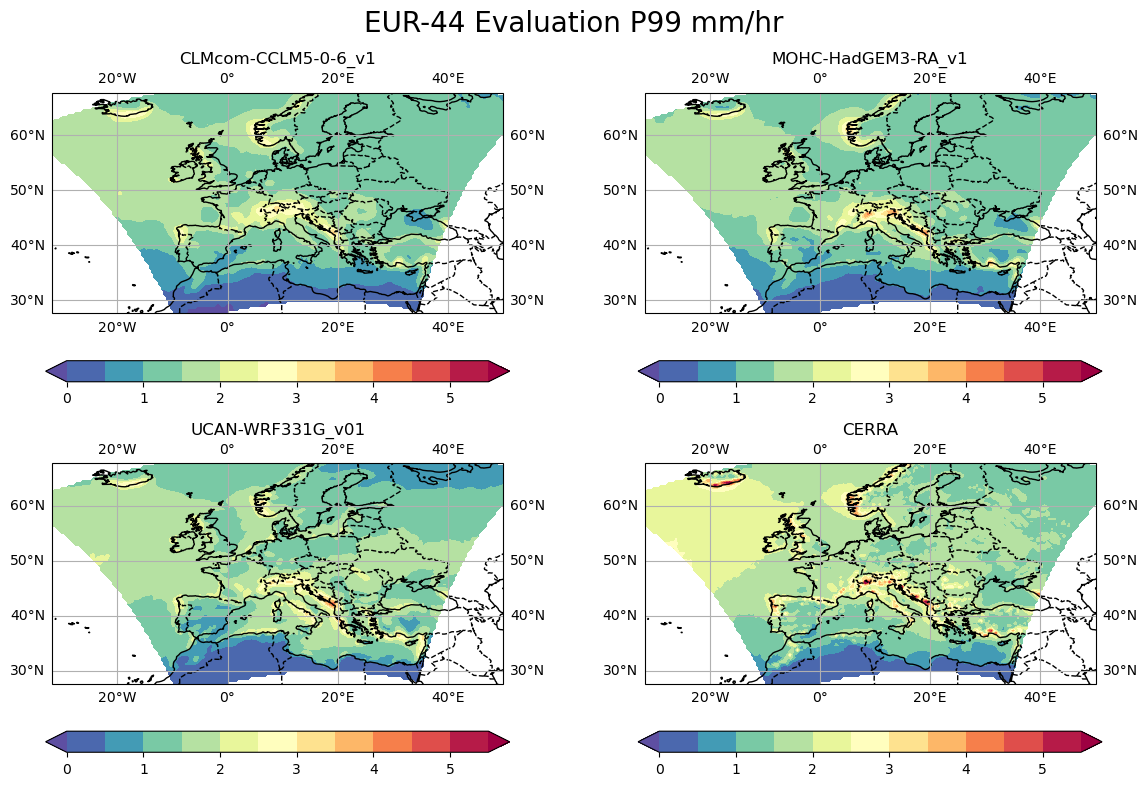

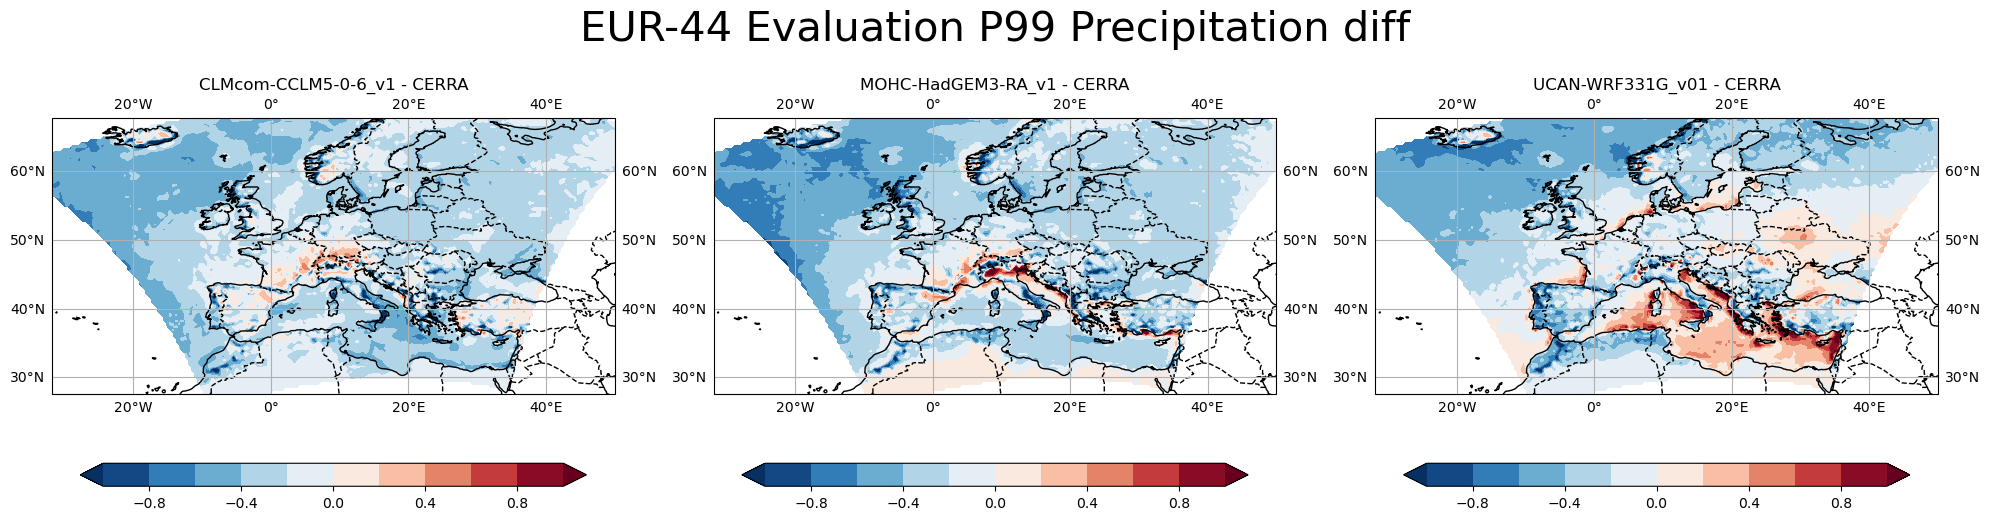

CPU times: user 1.96 s, sys: 3.84 ms, total: 1.97 s
Wall time: 2.53 s


In [50]:
%%time
year_s = 1990
year_e = 2010

res_EUR = 'EUR-44'

if res_EUR == 'EUR-44':
    DataName_1d = ['CLMcom-CCLM5-0-6_v1', 'MOHC-HadGEM3-RA_v1','UCAN-WRF331G_v01']
elif res_EUR == 'EUR-11':
    # name of analyzed dataset EUR-11
    DataName_1d = ['CLMcom-ETH-COSMO-crCLIM-v1-1_v1', \
                'MOHC-HadREM3-GA7-05_v1',\
                'ICTP-RegCM4-6_v1']

n_dataset = len(DataName_1d)
prec_p99 = np.zeros((n_dataset + 1, Lon.shape[0], Lon.shape[1]))

dir_o = '/glade/campaign/mmm/c3we/mingge/FRONTIERS/data/'
flnm_o = dir_o + 'prec_p99_' + res_EUR + '.nc' 
print(flnm_o)
ds = xr.open_dataset(flnm_o)

prec_p99 = ds.prec_p99.values

flnm_o = dir_o + 'prec_p99_CERRA.nc' 
print(flnm_o)
ds = xr.open_dataset(flnm_o)
prec_p99[n_dataset] = ds.prec_p99.values

# set data to NaN outside masked region
prec_p99[:, Mask == 0] = np.nan

plot_p4('44', 'Evaluation', Lat, Lon, DataName_1d + ['CERRA'], prec_p99)    
 

for nd in range(len(DataName_1d)):
    prec_p99[nd,:,:] = (prec_p99[nd] - prec_p99[-1]) 
                                           
plot_diff_p3('44', 'Evaluation', Lat, Lon, DataName_1d, prec_p99[:-1])


/glade/campaign/mmm/c3we/mingge/FRONTIERS/data/prec_p99_EUR-11.nc
/glade/campaign/mmm/c3we/mingge/FRONTIERS/data/prec_p99_CERRA.nc


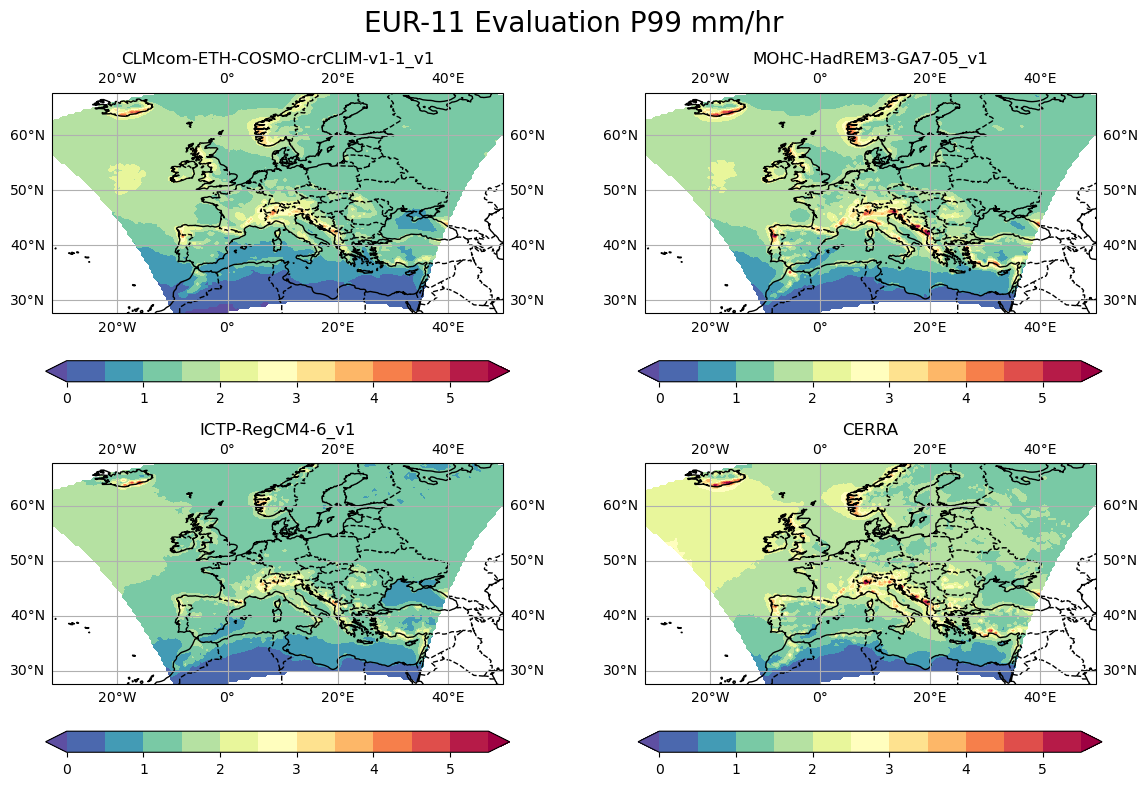

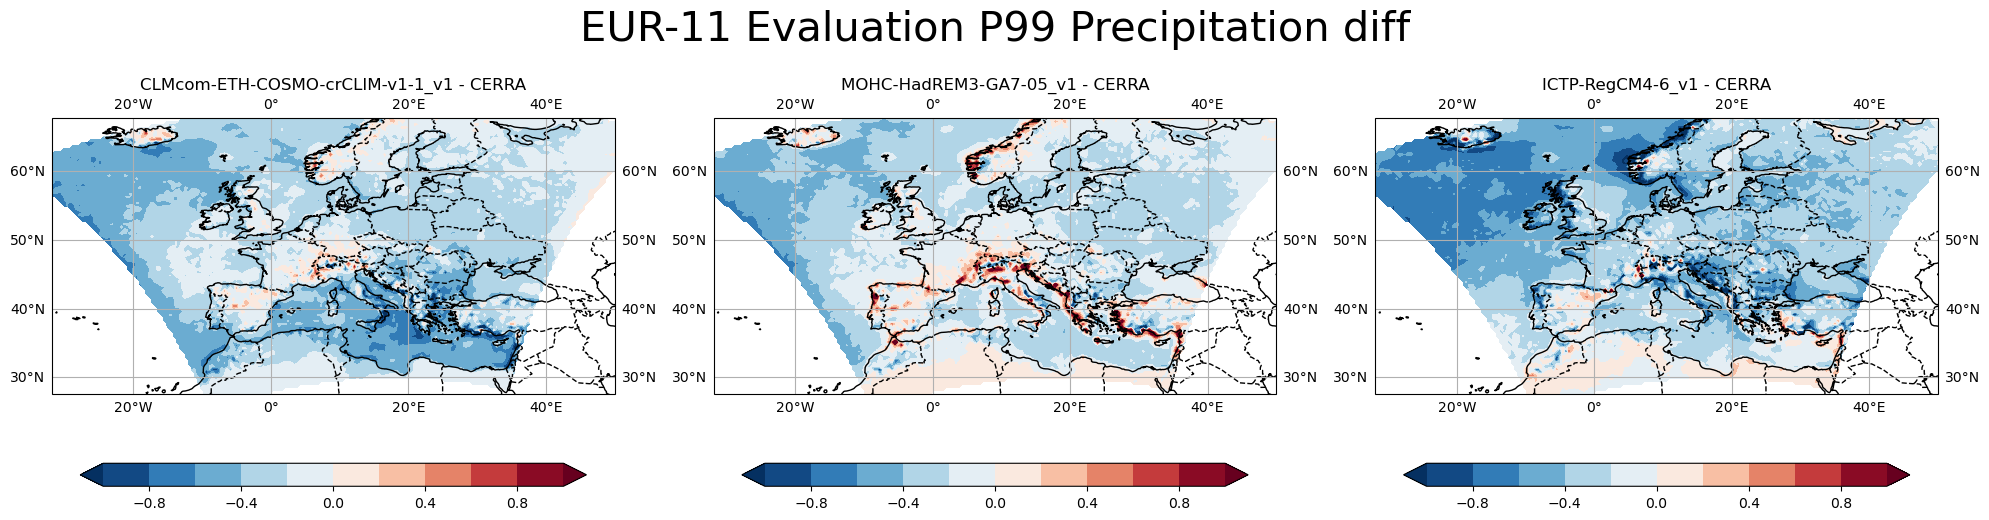

In [51]:
res_EUR = 'EUR-11'

if res_EUR == 'EUR-44':
    DataName_1d = ['CLMcom-CCLM5-0-6_v1', 'MOHC-HadGEM3-RA_v1','UCAN-WRF331G_v01']
elif res_EUR == 'EUR-11':
    # name of analyzed dataset EUR-11
    DataName_1d = ['CLMcom-ETH-COSMO-crCLIM-v1-1_v1', \
                'MOHC-HadREM3-GA7-05_v1',\
                'ICTP-RegCM4-6_v1']

n_dataset = len(DataName_1d)
prec_p99 = np.zeros((n_dataset + 1, Lon.shape[0], Lon.shape[1]))

dir_o = '/glade/campaign/mmm/c3we/mingge/FRONTIERS/data/'
flnm_o = dir_o + 'prec_p99_' + res_EUR + '.nc' 
print(flnm_o)
ds = xr.open_dataset(flnm_o)

prec_p99 = ds.prec_p99.values

flnm_o = dir_o + 'prec_p99_CERRA.nc' 
print(flnm_o)
ds = xr.open_dataset(flnm_o)
prec_p99[n_dataset] = ds.prec_p99.values

# set data to NaN outside masked region
prec_p99[:, Mask == 0] = np.nan

plot_p4('11', 'Evaluation', Lat, Lon, DataName_1d + ['CERRA'], prec_p99)    
 

for nd in range(len(DataName_1d)):
    prec_p99[nd,:,:] = (prec_p99[nd] - prec_p99[-1]) 
                                           
plot_diff_p3('11', 'Evaluation', Lat, Lon, DataName_1d, prec_p99[:-1])
